# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV
)
from sklearn.preprocessing import (
    OrdinalEncoder, 
    StandardScaler
)
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/autos.csv')
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
size = df.shape[0]
size

354369

In [5]:
df.isnull().sum() # анализируем пропуски

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

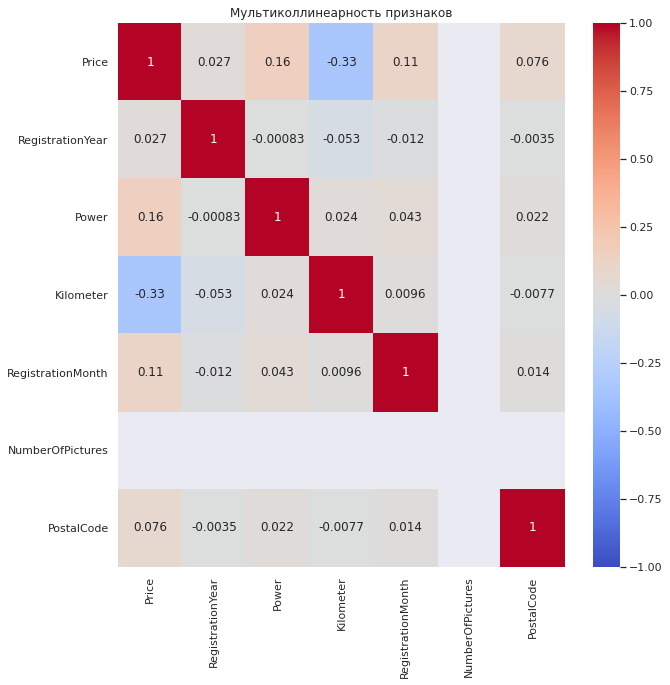

In [6]:
sns.set(rc={'figure.figsize': (10,10)})
sns.heatmap(
    df.corr(), vmin = -1, vmax = +1,
    annot = True, cmap = 'coolwarm'
)
plt.title('Мультиколлинеарность признаков')
plt.show()

In [7]:
df['NumberOfPictures'].unique()

# проверяем что в NumberOfPictures все объекты равны нулю

array([0])

In [8]:
df = df.drop(
    ['NumberOfPictures','DateCrawled', 'LastSeen',
     'DateCreated', 'RegistrationMonth', 'PostalCode',
     'NumberOfPictures'], axis=1
)

# удаляем признаки которые не относятся к характеристикам авто и поэтому не влияют на продажи

In [9]:
df['Repaired'] = df['Repaired'].fillna('NA')
df['FuelType'] = df['FuelType'].fillna('NA')
df['Model'] = df['Model'].fillna('NA')
df['Gearbox'] = df['Gearbox'].fillna('NA')
df['VehicleType'] = df['VehicleType'].fillna('NA')

# заполняем пропуски NA

In [10]:
columns = list(df.columns)
columns

['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

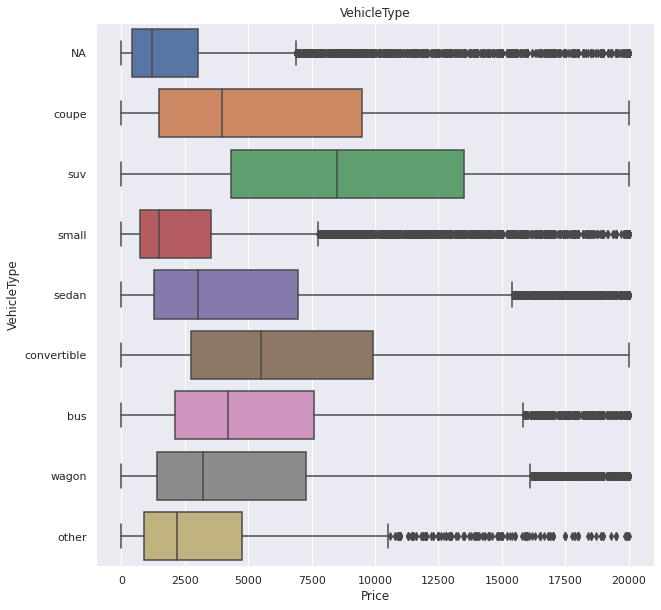

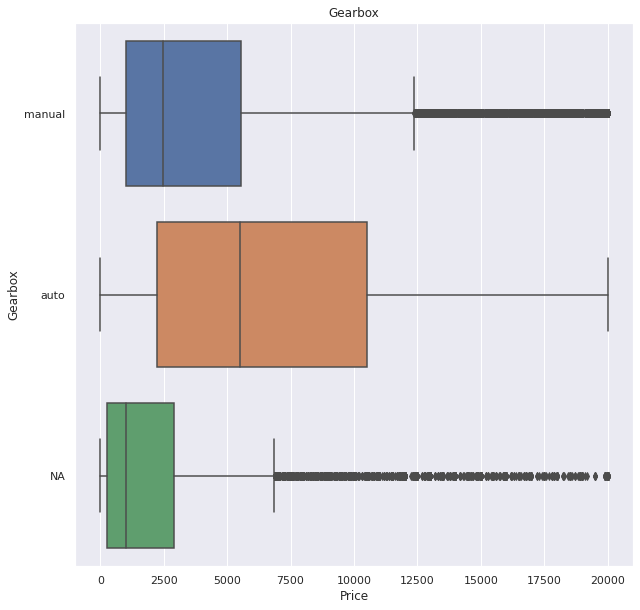

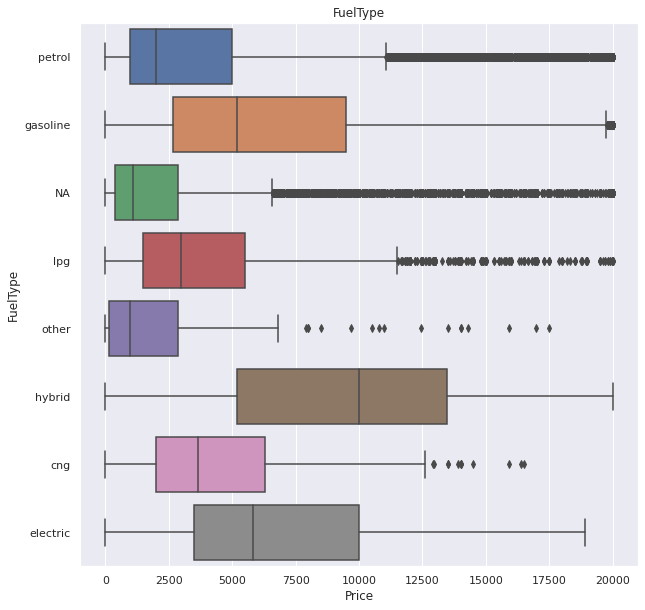

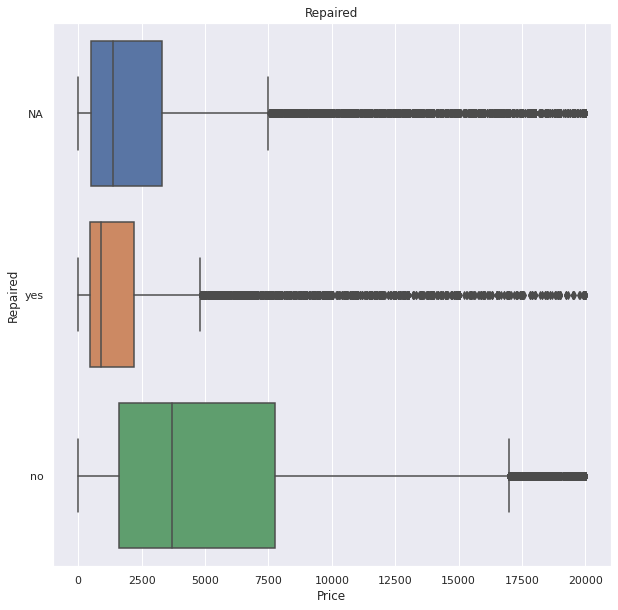

In [11]:

for i in ['VehicleType','Gearbox','FuelType','Repaired']:
    sns.boxplot(y=i, x='Price', data=df)
    plt.title(i)
    plt.show() 

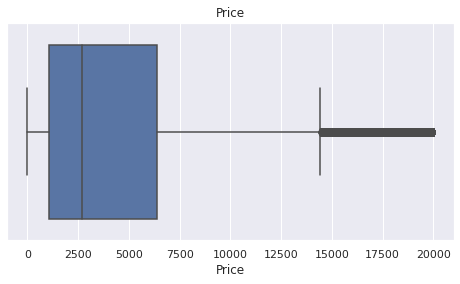

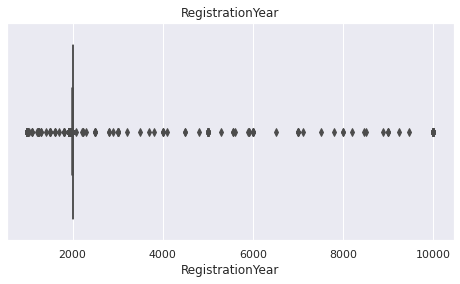

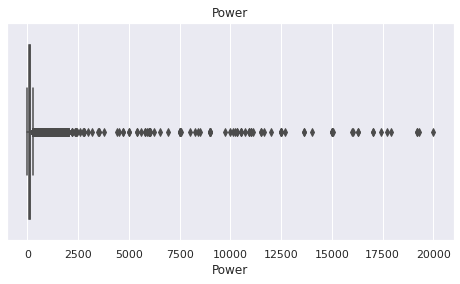

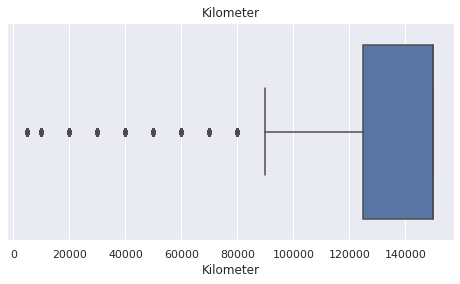

In [12]:
sns.set(rc={'figure.figsize':(8,4)})
for i in ['Price', 'RegistrationYear', 'Power', 'Kilometer']:
    sns.boxplot(df[i])
    plt.title(i)
    plt.show()

- Проанализировав признаки на выбросы можно сделать корректировку по признаку RegistrationYear ( 1900 < RegistrationYear < 2022) и Power ( 20 < Power < 1500)

In [13]:
df = df[(df['RegistrationYear'] > 1900)&(df['RegistrationYear'] < 2022)]
df['RegistrationYear'].count() / size

# ограничиваем год регистрации с 1900 по 2023 и убеждаемся, что потеряли менее 1% данных

0.9995174521473379

In [14]:
df = df[(df['Power'] > 20)&(df['Power'] < 1500)]
df['Power'].count() / size

# ограничиваем мощность с 20 по 1500 и убеждаемся, что потеряли менее 12% данных

0.8845638303576215

<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены следующие изменения: <br>
    - ограничили стоимость так что бы Price > 100
    
</div>

In [15]:
df = df[(df['Price'] > 100)]
df['Price'].count() / size

0.8599651775409248

In [16]:
df= df.reset_index().drop('index', axis=1)

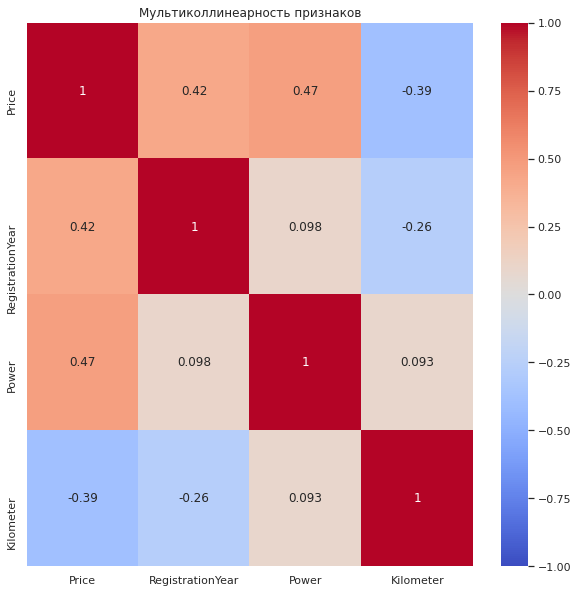

In [17]:
sns.set(rc={'figure.figsize': (10,10)})
sns.heatmap(
    df.corr(), vmin = -1, vmax = +1,
    annot = True, cmap = 'coolwarm'
)
plt.title('Мультиколлинеарность признаков')
plt.show()

# посмотрим на мультиколлинеарность после всех преобразований

**Выводы**

- загрузили датасет и проверили на пропуски и формат данных
- пропуски заполнили на 'NA'
- выбросы по RegistrationYear и Power ограничили интервалами сохранив более 88% датасета
- анамально малые значения Price ограничили суммой более 100 сохранив более 85% датасета
- псомотрели признаки на мультиколлениарность - самая сильная прямая завсимость Price от Power 

<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены следующие изменения: <br>
    - ограничили стоимость так что бы Price > 100
    
</div>

## Обучение моделей

### LinearRegression

In [18]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.3, random_state=12345)
# формеруем тренировочные и тестовые выборки

features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)
# производим прямое кодирование

numeric = ['RegistrationYear', 'Power', 'Kilometer']
# выделяем признаки для маштабирования

scaler = StandardScaler()
scaler.fit(features_train[numeric])
# производим настройку маштабирования на тренировочных данных

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()
# преобразуем обучающую и валидационную выборки функцией transform()

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_yes
186026,-1.495367,-1.165565,0.586929,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
206888,-0.482905,-0.120079,0.586929,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25301,0.240283,0.332965,0.586929,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
115016,-0.193630,-0.973893,0.586929,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
93831,0.095645,0.733735,0.586929,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0


<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены следующие изменения: <br>
    - прямое кодирование произведено после разбиения на выборки
    
</div>

In [19]:
print(features_train.shape)
print(features_test.shape)

(213321, 310)
(91424, 306)


In [20]:
features_train = features_train[features_test.columns]
print(features_train.shape)
print(features_test.shape)
# удалили лишние признаки в features_train после кодирования

(213321, 306)
(91424, 306)


<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены следующие изменения: <br>
    - выровнили кол-во признаков в тренировочной и тестовой выборке после кодирования
    
</div>

In [21]:
%%time

score_lr = cross_val_score(LinearRegression(), features_train, target_train, 
                              cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
score_lr.mean()

# обучаем модель LR кросс-валидацией с замерением времени выполнения ячейки

CPU times: user 42.9 s, sys: 36.4 s, total: 1min 19s
Wall time: 1min 19s


-2637.8354050409393

In [22]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)


CPU times: user 11.2 s, sys: 9.71 s, total: 20.9 s
Wall time: 20.9 s


LinearRegression()

In [23]:
%%time
prediction_lr = model_lr.predict(features_train)

CPU times: user 61.8 ms, sys: 73.3 ms, total: 135 ms
Wall time: 112 ms


In [41]:
results = {
    'wall_time_fit': [],
    'wall_time_predict': [],
    'rmse': []
}
results['rmse'].append(score_lr.mean())
results['wall_time_fit'].append(21)
results['wall_time_predict'].append(114/1000)
results

{'wall_time_fit': [21],
 'wall_time_predict': [0.114],
 'rmse': [-2637.8354050409393]}

**Выводы по LinearRegression**

-  время на обучение составило  21сек
-  время на предсказания составило 114 милисек
-  точность по метрике rmse -2637

### CatBoost

In [25]:
features_cat = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.3, random_state=12345)

In [26]:
params = {
    'learning_rate':[0.1, 0.8],
    'depth':[2, 12],
    'l2_leaf_reg': [1, 8]    
}

grid = GridSearchCV(CatBoostRegressor(loss_function="RMSE", iterations=100, silent=True),
                    param_grid=params,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    verbose=False)

grid.fit(features_train_boost, target_train_boost, cat_features=features_cat)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f05600058e0>,
             param_grid={'depth': [2, 12], 'l2_leaf_reg': [1, 8],
                         'learning_rate': [0.1, 0.8]},
             scoring='neg_mean_squared_error', verbose=False)

In [27]:
grid.best_params_

{'depth': 12, 'l2_leaf_reg': 8, 'learning_rate': 0.8}

In [28]:
%%time

score_cb = cross_val_score(CatBoostRegressor(loss_function="RMSE", iterations=200,
                        learning_rate=0.8, depth=12, l2_leaf_reg=8, silent=True),
                        features_train, target_train, 
                        cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
score_cb.mean()

# обучаем модель CB кросс-валидацией с замерением времени выполнения ячейки

CPU times: user 1min 18s, sys: 412 ms, total: 1min 18s
Wall time: 1min 20s


-1579.3849376803998

In [29]:
%%time
model_cb = CatBoostRegressor(loss_function="RMSE", iterations=200, 
                              learning_rate=0.8, depth=12, l2_leaf_reg=8, silent=True)

model_cb.fit(features_train_boost, target_train_boost, cat_features=features_cat)

CPU times: user 2min 12s, sys: 412 ms, total: 2min 12s
Wall time: 2min 13s


In [30]:
%%time
prediction_cb = model_cb.predict(features_train_boost)

CPU times: user 457 ms, sys: 7.14 ms, total: 464 ms
Wall time: 470 ms


In [42]:
results['rmse'].append(score_cb.mean())
results['wall_time_fit'].append("2:13")
results['wall_time_predict'].append(470/1000)
results

{'wall_time_fit': [21, '2:13'],
 'wall_time_predict': [0.114, 0.47],
 'rmse': [-2637.8354050409393, -1579.3849376803998]}

 **Выводы по CatBoost**

-  время на обучение составило 2мин 42сек
-  время на предсказания составило 687 милисек
-  точность по метрике rmse 1706

### LightGBM

In [32]:
features_train_boost[features_cat] = features_train_boost[features_cat].astype('category')
features_test_boost[features_cat] = features_test_boost[features_cat].astype('category')
features_test_boost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91424 entries, 197840 to 63186
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       91424 non-null  category
 1   RegistrationYear  91424 non-null  int64   
 2   Gearbox           91424 non-null  category
 3   Power             91424 non-null  int64   
 4   Model             91424 non-null  category
 5   Kilometer         91424 non-null  int64   
 6   FuelType          91424 non-null  category
 7   Brand             91424 non-null  category
 8   Repaired          91424 non-null  category
dtypes: category(6), int64(3)
memory usage: 3.4 MB


In [33]:
params = {
    'learning_rate': [0.1, 0.6],
    'max_depth': [3, 9],
    'num_leaves': [30, 90, 10],
    
}

grid = GridSearchCV(LGBMRegressor(random_state=12345, num_iterations=200),
                    param_grid=params,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    verbose=False)

grid.fit(features_train_boost, target_train_boost, categorical_feature=features_cat)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(num_iterations=200, random_state=12345),
             param_grid={'learning_rate': [0.1, 0.6], 'max_depth': [3, 9],
                         'num_leaves': [30, 90, 10]},
             scoring='neg_mean_squared_error', verbose=False)

In [34]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 90}

In [35]:
%%time

score_lg = cross_val_score(LGBMRegressor(random_state=12345, num_iterations=200, min_data_in_leaf=50,
                        learning_rate=0.1, max_depth=9, num_leaves=90, boost='gbdt'),
                        features_train, target_train, 
                        cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
score_lg.mean()

# обучаем модель LG кросс-валидацией с замерением времени выполнения ячейки

[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
CPU times: u

-1634.1643486057594

In [36]:
%%time

model_lg = LGBMRegressor(random_state=12345, num_iterations=200, min_data_in_leaf=50, 
                           learning_rate=0.1, max_depth=9, num_leaves=90, boost='gbdt')

model_lg.fit(features_train_boost, target_train_boost, categorical_feature=features_cat)

[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
CPU times: user 13.5 s, sys: 49.2 ms, total: 13.5 s
Wall time: 13.5 s


LGBMRegressor(boost='gbdt', max_depth=9, min_data_in_leaf=50,
              num_iterations=200, num_leaves=90, random_state=12345)

In [37]:
%%time
prediction_lg = model_lg.predict(features_train_boost)

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.6 s


In [43]:
results['rmse'].append(score_lg.mean())
results['wall_time_fit'].append("13.5")
results['wall_time_predict'].append('2.6')
results

{'wall_time_fit': [21, '2:13', '13.5'],
 'wall_time_predict': [0.114, 0.47, '2.6'],
 'rmse': [-2637.8354050409393, -1579.3849376803998, -1634.1643486057594]}

**Выводы по LightGBM**

-  время на обучение составило 15сек
-  время на предсказания составило 3 сек
-  точность по метрике rmse 1658

## Анализ моделей

In [44]:
pd.DataFrame(results, index=['LR', 'CB', 'LG'])

,wall_time_fit,wall_time_predict,rmse
LR,21,0.114,-2637.835405
CB,2:13,0.47,-1579.384938
LG,13.5,2.6,-1634.164349


Лучшая модель по соотношению скорость и точность - LGBMRegressor(boost='gbdt', max_depth=9, min_data_in_leaf=50, num_iterations=200, num_leaves=90, random_state=12345)

## Тестирование лучшей модели LightGBM

Исходя из показателей время-качество лучше всего зарекомендовала себя модель LGBMRegressor
(random_state=12345, num_iterations=200),param_grid=params, cv=5,scoring='neg_mean_squared_error',
                    verbose=False)

In [40]:
%%time

prediction = model_lg.predict(features_test_boost)
lgbm_rmse = mean_squared_error(target_test_boost, prediction) ** 0.5
lgbm_rmse
# проводим проверку на тестовой выборке

[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
CPU times: user 2min 7s, sys: 427 ms, total: 2min 8s
Wall time: 2min 8s


1566.5325073150084

**Вывод:**

- Метрика RMSE на тестовой выборке показала 1566, что удовлитворяет поставленной задачи